### Setup

In [1]:
from typing import List
from openai import OpenAI
from tonic_validate import ValidateScorer, Benchmark, BenchmarkItem, LLMResponse, BenchmarkItem, Run
from tonic_validate.metrics import AnswerSimilarityMetric
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import os
import time
import json
import pandas as pd
import matplotlib.pyplot as plt

# os.environ['OPENAI_API_KEY'] = "YOUR_OPENAI_API_KEY"


with open("qa_pairs.json", "r") as f:
    qa_pairs = json.load(f)

# for testing
qa_pairs = qa_pairs

benchmark = Benchmark(
    questions=[x["question"] for x in qa_pairs],
    answers=[x["answer"] for x in qa_pairs]
)

def run_to_dataframe(run: Run) -> pd.DataFrame:
    return pd.DataFrame(
        {
            "reference_question": [x.reference_question for x in run.run_data],
            "reference_answer": [x.reference_answer for x in run.run_data],
            "llm_answer": [x.llm_answer for x in run.run_data],
            "llm_context": [json.dumps(x.llm_context) for x in run.run_data],
            "answer_similarity": [x.scores["answer_similarity"] for x in run.run_data]
        }
    )

### CustomGPT Conversation


#### Setup

In [2]:
from customgpt_client import CustomGPT
from customgpt_client.types import File
import uuid
CustomGPT.api_key = os.environ["CUSTOM_GPT_API_KEY"]

def get_customgpt_rag_response(benchmarkItem: BenchmarkItem, project):
    prompt = benchmarkItem.question
    conversation_id = uuid.uuid4()
    max_retries = 3
    run_count = 0

    while run_count < max_retries:
        try:
            response = CustomGPT.Conversation.send(project_id=project.id, session_id=conversation_id, prompt=prompt)
            if response.status_code == 200:
                openai_response = response.parsed.data.openai_response
            else:
                raise Exception(f"Failed in generating CustomGPT Response::{response.status_code}")
            return openai_response
        except Exception as e:
            run_count += 1
            time.sleep(2)


def setup_project():
    file_ids = []
    project = CustomGPT.Project.create(project_name="Rag Evaluation")
    if project.status_code == 201:
        project_id = project.parsed.data.id

        source = CustomGPT.Source.create(project_id=project_id, file=File(payload=open("all_essays_in_single_file.txt", 'rb'), file_name=f"Paul Graham Essay"))

        is_chat_active = 0
        # Check to make sure at least one page is indexed
        while not is_chat_active:
            response_project = CustomGPT.Project.get(project_id=project_id)
            json_project = response_project.parsed
            is_chat_active = json_project.data.is_chat_active
            time.sleep(5)

        return project.parsed.data
    else:
        raise Exception("CustomGPT Project Creation Failed")
    pass

project = setup_project()


#### Testing

In [3]:

benchmark_item = BenchmarkItem(
    question="What key components are necessary to create a technology hub according to Paul Graham?",
    answer=""
)

print(get_customgpt_rag_response(benchmark_item, project))

According to Paul Graham, the key components necessary to create a technology hub include:

- **Presence of a First-rate Research University**: A top-tier university acts as a source of new ideas and talent, which is essential for fostering innovation and startup culture.

- **An Attractive Location for Living**: The place should be appealing enough that it attracts wealthy individuals and investors, as well as founders, to live there.

- **Rich People and Nerds (Investors and Founders)**: A combination of investors who provide capital and founders who bring in innovation is critical. These are the people who create technology, and their presence is a fundamental requirement for a startup hub.

- **Face-to-Face Meetings**: The value of physical interactions is emphasized as irreplaceable, even with advancements in technology. Casual, in-person encounters can lead to the exchange of ideas and solutions that are beneficial for startups.

- **A Self-Sustaining Chain Reaction**: Once a cri

##### Run through all the questions

In [4]:
raw_customgpt_responses = []
for x in tqdm(benchmark.items):
    raw_customgpt_responses.append(get_customgpt_rag_response(x, project))


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [31:22<00:00, 34.23s/it]


In [5]:
customgpt_responses = [
    LLMResponse(
        llm_answer=r, llm_context_list=[], benchmark_item=bi
    ) for r, bi in zip(raw_customgpt_responses, benchmark.items)
]

In [6]:
scorer = ValidateScorer([AnswerSimilarityMetric()])
customgpt_run = scorer.score_run(customgpt_responses, parallelism=5)

In [7]:
customgpt_run_df = run_to_dataframe(customgpt_run)
customgpt_run_df.to_csv("customgpt_run.csv", index=False)

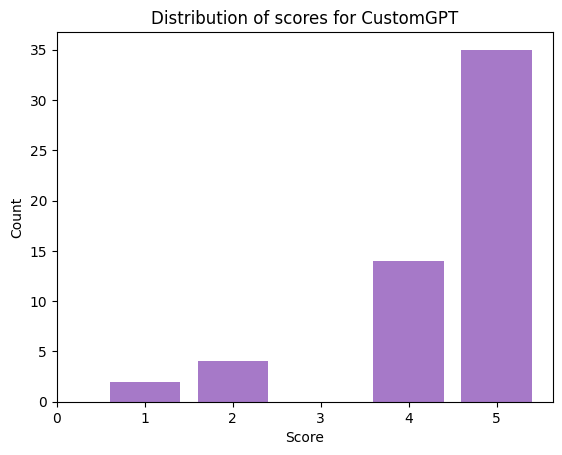

In [8]:
customgpt_answer_similarity_scores = pd.Series([x.scores["answer_similarity"] for x in customgpt_run.run_data])
category_counts = customgpt_answer_similarity_scores.value_counts()
plt.bar(category_counts.index, category_counts.values)

plt.title('Distribution of scores for CustomGPT')
plt.xlabel('Score')
plt.ylabel('Count')

plt.bar(category_counts.index, category_counts.values, color='#A679C8')

# Remove all scores except whole numbers
plt.xticks(range(0, 6, 1))

plt.show()

### OpenAI Rag Assistant

#### Setup

In [9]:
def get_openai_rag_response(benchmarkItem: BenchmarkItem, assistant):
    prompt = benchmarkItem.question
    thread = client.beta.threads.create(
        messages=[
            {
                "role": "user",
                "content": prompt
            }
        ]
    )
    run = client.beta.threads.runs.create(
        thread_id=thread.id,
        assistant_id=assistant.id,
    )
    max_retries = 10
    base = 0.1
    num_retries = 0
    try:
        while max_retries > 0:
            if max_retries == 0:
                client.beta.threads.delete(thread.id)
                raise Exception("Max tries exceeded")
            messages = client.beta.threads.messages.list(
                thread_id=thread.id,
            )
            if len(messages.data)>0 and len(messages.data[0].content)>0:
                response_message = messages.data[0].content[0].text.value
                if response_message != prompt and response_message.strip():
                    annotations = messages.data[0].content[0].text.annotations
                    quotes = [x.file_citation.quote for x in annotations if x.file_citation]
                    client.beta.threads.delete(thread.id)
                    return response_message
            time.sleep(base * (2 ** num_retries))
            num_retries += 1
            max_retries -= 1
    except Exception as e:
        print(e)
        client.beta.threads.delete(thread.id)
        raise e

#openai rag only supports a max of 20 files. So we just combine all essays into single file
def upload_essay():
    file_ids=[]
    with open("all_essays_in_single_file.txt", 'rb') as essay_file:
        file = client.files.create(
            file=essay_file,
            purpose='assistants'
        )
        file_ids.append(file.id)
    return file_ids

def create_assistant(file_ids):
    return client.beta.assistants.create(
        name=f"OpenAI Rag Test {len(file_ids)} Files",
        instructions=(
            "You are a chatbot that answers questions about Paul Graham's essays. "
            "Use your knowledge base to best respond to questions. "
            "NO MATTER WHAT, DO NOT PULL INFORMATION FROM EXTERNAL KNOWLEDGE. ONLY USE YOUR OWN KNOWLEDGE BASE."
        ),
        model="gpt-4-1106-preview",
        tools=[{"type": "retrieval"}],
        file_ids=file_ids
    )

def setup_assistant():
    file_ids = upload_essay()
    return create_assistant(file_ids)

# WARNING
# this deletes all files associated with your openai api key.
#def cleanup_files():
#    for f in client.files.list():
#        client.files.delete(f.id)
#        time.sleep(1)

#### Testing

In [10]:
client = OpenAI()
assistant = setup_assistant()

In [11]:
benchmark_item = BenchmarkItem(
    question="What key components are necessary to create a technology hub according to Paul Graham?",
    answer=""
)

print(get_openai_rag_response(benchmark_item, assistant))

According to Paul Graham, there are several key components necessary to create a technology hub:

1. Attracting the "Creative Class": Cities will prosper if they attract creative individuals who generate wealth through ideas, a principle that was even evident in Amsterdam's prosperity 400 years ago. To attract the so-called "creative class," towns must have personality, meaning they should feel distinctive and not mass-produced. This often includes well-preserved old neighborhoods, locally-owned shops and restaurants over national chains, and a general avoidance of large development projects that give a uniform appearance to the area【9†source】.

2. A Place with the Right Personality: For technology hubs, it's crucial to attract a specific subset of the creative class—nerds. These individuals prefer towns with personality that cater to quieter pleasures, such as cafes, used bookshops, hiking, and sunlight. A place like Berkeley or Boulder would be considered ideal as they embody these q

##### Run through all the questions

In [12]:
raw_openai_responses = []
for x in tqdm(benchmark.items):
    raw_openai_responses.append(get_openai_rag_response(x, assistant))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [27:01<00:00, 29.49s/it]


In [13]:
openai_responses = [
    LLMResponse(
        llm_answer=r, llm_context_list=[], benchmark_item=bi
    ) for r, bi in zip(raw_openai_responses, benchmark.items)
]

In [14]:
scorer = ValidateScorer([AnswerSimilarityMetric()])
openai_run = scorer.score_run(openai_responses, parallelism=5)

In [15]:
openai_run_df = run_to_dataframe(openai_run)
openai_run_df.to_csv("openai_run.csv", index=False)

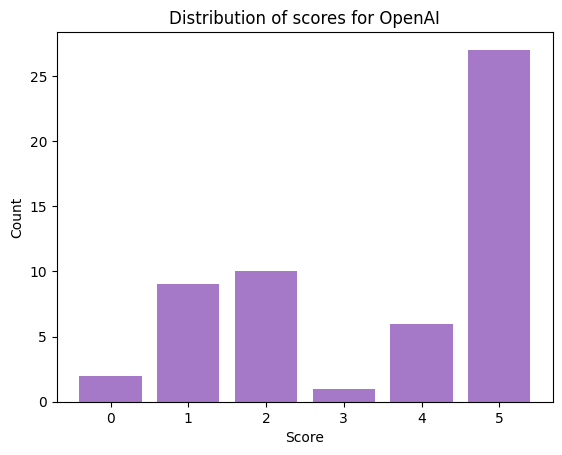

In [16]:
openai_answer_similarity_scores = pd.Series([x.scores["answer_similarity"] for x in openai_run.run_data])
category_counts = openai_answer_similarity_scores.value_counts()
plt.bar(category_counts.index, category_counts.values)

plt.title('Distribution of scores for OpenAI')
plt.xlabel('Score')
plt.ylabel('Count')

plt.bar(category_counts.index, category_counts.values, color='#A679C8')

# Remove all scores except whole numbers
plt.xticks(range(0, 6, 1))

plt.show()

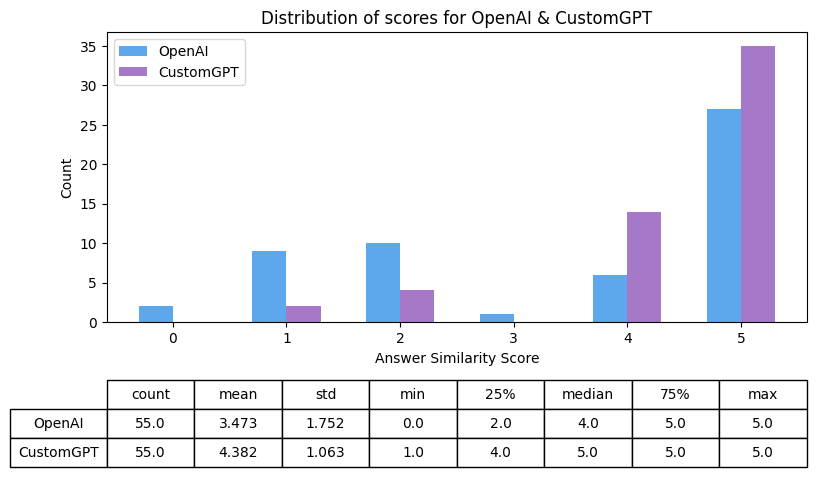

In [17]:
import matplotlib.pyplot as plt
import numpy as np

openai_run_df = pd.read_csv("openai_run.csv")
customgpt_run_df = pd.read_csv("customgpt_run.csv")

combined_scores = pd.DataFrame({
    "OpenAI": list(openai_run_df["answer_similarity"]),
    "CustomGPT": list(customgpt_run_df["answer_similarity"])
})

# Position of bars on x-axis
ind = np.arange(6)

# Figure size
plt.figure(figsize=(10,5))

# Width of a bar
width = 0.3

openai_counts = combined_scores["OpenAI"].value_counts().reindex([0,1,2,3,4,5], fill_value=0)
plt.bar(openai_counts.index, openai_counts.values, width, label="OpenAI", color="#5EA7EC")

customgpt_counts = combined_scores["CustomGPT"].value_counts().reindex([0,1,2,3,4,5], fill_value=0)
plt.bar(customgpt_counts.index + width, customgpt_counts.values, width, label="CustomGPT", color="#A679C8")

plt.title('Distribution of scores for OpenAI & CustomGPT')
plt.xlabel('Answer Similarity Score')
plt.ylabel('Count')

# Remove all scores except whole numbers
plt.xticks(ind + width / 2, range(0, 6, 1))

plt.legend(loc='best')

# Rounding the descriptive statistics to 3 significant figures
statistics_df = combined_scores.describe()
# Change 50% to 50% (median)
statistics_df = statistics_df.rename(index={'50%': 'median'})
rounded_statistics_df = statistics_df.round(3)

# Transposing the descriptive statistics table for horizontal display
rounded_statistics_df = rounded_statistics_df.T

# Adding the table below the histogram
table = plt.table(cellText=rounded_statistics_df.values,
                  colWidths=[0.1] * len(rounded_statistics_df.columns),
                  rowLabels=rounded_statistics_df.index,
                  colLabels=rounded_statistics_df.columns,
                  cellLoc = 'center', rowLoc = 'center',
                  loc='bottom', bbox=[0.0, -0.5, 1.0, 0.3])

plt.subplots_adjust(left=0.2, bottom=0.3)
plt.savefig("openai_v_customgpt.png", facecolor='white', bbox_inches='tight')

plt.show()